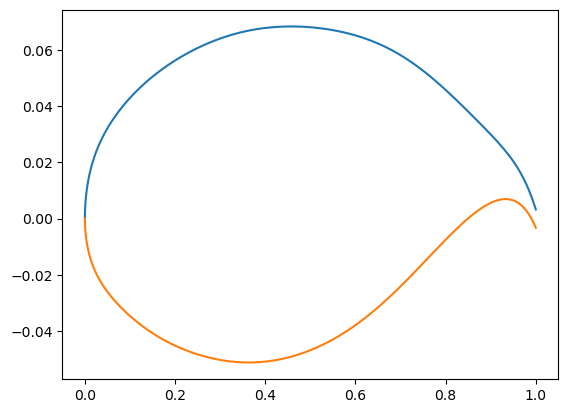

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
from numpy.linalg import lstsq
from scipy.special import factorial
import matplotlib.pyplot as plt
class CSTLayer():
    def __init__(self,x_coords =None,n_cst = 12, n_x = 129, n1=0.5, n2=1.0):
        if x_coords is None: # use n_x to generate x_coords
            '''
            only work for same x coordinates for both side of airfoil
            airfoil points from upper TE ---> LE ---> lower TE
            n_cst为cst拟合的阶数,x_coords为原始翼型的x坐标,n_x在没有输入x坐标时起作用
            '''
            self.n_x = n_x
            theta = np.linspace(np.pi, 2*np.pi, n_x)
            self.x_coords = (np.cos(theta) + 1.0)/2
        else:
            self.n_x = len(x_coords)
            self.x_coords = x_coords

        self.n1 = n1
        self.n2 = n2
        self.n_cst = n_cst
        self.A0 = self.A0_matrix()
      
    def A0_matrix(self):
        '''
        y = A0.T.dot(au) + 0.5 * te * x
        '''
        n = self.n_cst
        n1 = self.n1
        n2 = self.n2
        n_x = self.n_x
        x = self.x_coords
        k=np.zeros(n+1)
        A0 = np.zeros([n+1,n_x])
        
        for r in range(n+1):
            k[r] = factorial(n)/factorial(r)/factorial(n-r)
            A0[r,:] = k[r]*x**(n1 + r)*(1 - x)**(n + n2 - r)
        return A0.T
    
    def fit_CST(self, y_coords,n_x=129):
        A0 = self.A0_matrix()
        yu = y_coords[:n_x][::-1]#上表面的翼型，
        #这里读取的y是从后缘一直到前缘，再到翼型后缘，因此这里有一个反转顺序的过程，根据你初始翼型而定
        # print(yu)
        yl = y_coords[n_x-1:]#下表面的翼型
        # print(yl)
        te = (yu[-1]-yl[-1])
        au = lstsq(A0,yu-self.x_coords*yu[-1],rcond=None)[0]
        al = lstsq(A0,yl-self.x_coords*yl[-1],rcond=None)[0]
        return au,al,te
y = np.load('data/data_z.npz')['y'][0]#读取初始翼型
cst=CSTLayer()
au,al,te = cst.fit_CST(y)#拟合中的x坐标和数量需要与原始翼型一致
yu = cst.A0.dot(au) + cst.x_coords*te#cst.x_coords可以替换成你需要的x坐标分布
yl = cst.A0.dot(al) - cst.x_coords*te
plt.plot(cst.x_coords,yu)
plt.plot(cst.x_coords,yl)

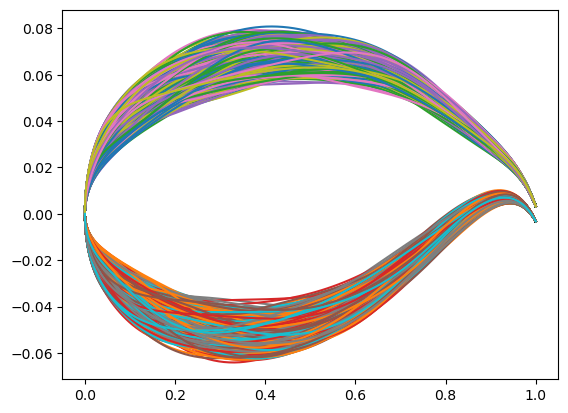

In [77]:
import numpy as np
import random
def lhs(n, au , al , te, bounds=[-0.05 , 0.05]):
  nvars = len(au) # 变量个数
  result_au = np.zeros((n, nvars))
  result_al = np.zeros((n, nvars))
  result_te = np.full((n, 1),te)
  # 对每个变量进行分区
  for i in range(nvars):
    
    partitions = np.linspace(au[i] + bounds[0], au[i] + bounds[1], n + 1)
    result_au[:, i] = np.random.permutation(partitions[:-1]) + np.random.uniform(0,abs(bounds[0]-bounds[1])/n,(n,))
  for i in range(nvars):
  
    partitions = np.linspace(al[i] + bounds[0], al[i] + bounds[1], n + 1)
    result_al[:, i] = np.random.permutation(partitions[:-1]) + np.random.uniform(0,abs(bounds[0]-bounds[1])/n,(n,))
  
  np.random.shuffle(result_au)
  np.random.shuffle(result_al)
  
  return result_au,result_al,result_te

# 使用示例
n = 1000  # 样本数量


au,al,te = lhs(n, au , al , te)

for i in range(n):
  yu = cst.A0.dot(au[i]) + cst.x_coords*te[i]
  yl = cst.A0.dot(al[i]) - cst.x_coords*te[i]
  plt.plot(cst.x_coords,yu)
  plt.plot(cst.x_coords,yl)

